## Seminar 1: Item2item Collaborative Filtering

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from random import sample

from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr

from functools import lru_cache
from typing import Tuple, Callable, List

Firstly, let's download the MovieLens dataset:

In [2]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip
    !unzip recsys.zip

--2024-10-30 07:53:45--  https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nzhinusoftcm/review-on-collaborative-filtering/master/recsys.zip [following]
--2024-10-30 07:53:46--  https://raw.githubusercontent.com/nzhinusoftcm/review-on-collaborative-filtering/master/recsys.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15312323 (15M) [application/zip]
Saving to: ‘recsys.zip’

recsys.zip          100%[===================>]  14.60M  35.7MB/s    in 0.4s    

2024-10-30 07:53:47 (35.7 MB/s) - ‘recsys.zip’ saved 

In [3]:
from recsys.datasets import ml1m, ml100k

ratings, movies = ml100k.load()

Download data 100.2%
Successfully downloaded ml-100k.zip 4924029 bytes.
Unzipping the ml-100k.zip zip file ...


Let's look at the data:

In [4]:
ratings.head()

,userid,itemid,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [5]:
movies.head()

,itemid,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
movies['year'] = movies['title']

In [7]:
'Copycat (1995)'[-5:-1]

'1995'

In [8]:
(
    (lambda x: int(x.split(' ')[-1][1:-1]))('Copycat (1995)'),
    (lambda x: int(x[x.find('(')+1:-1]))('Copycat (1995)'),
)

(1995, 1995)

In [9]:
movies['year'] = movies['year'].apply(lambda title: title[-5:-1])
movies['year']

,year
0,1995
1,1995
2,1995
3,1995
4,1995
...,...
1677,1997
1678,1998
1679,1998
1680,1994


In [10]:
# sorted(movies['year'].copy())[-100:]

In [11]:
# movies['year'].max(), movies['year'].min()

### 1. EDA

In [12]:
print(f"Ratings data shape: {ratings.shape}")
print(f"Movies data shape: {movies.shape}")

Ratings data shape: (100000, 3)
Movies data shape: (1682, 3)


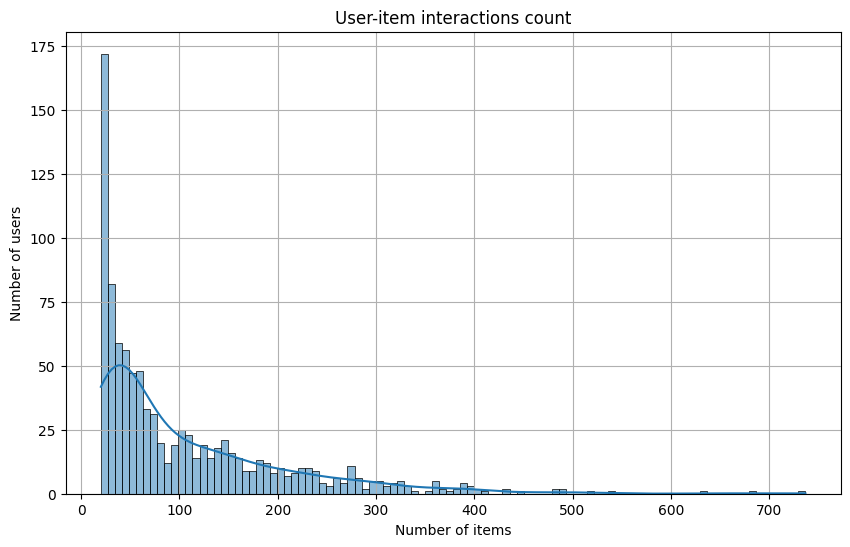

In [13]:
user_item_counts = ratings.groupby('userid')['itemid'].count().values

# Plot the histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(user_item_counts, bins=100, kde=True);
ax.set(xlabel="Number of items", ylabel="Number of users", title='User-item interactions count')
ax.grid()

Also, we can check the distribution of ratings:

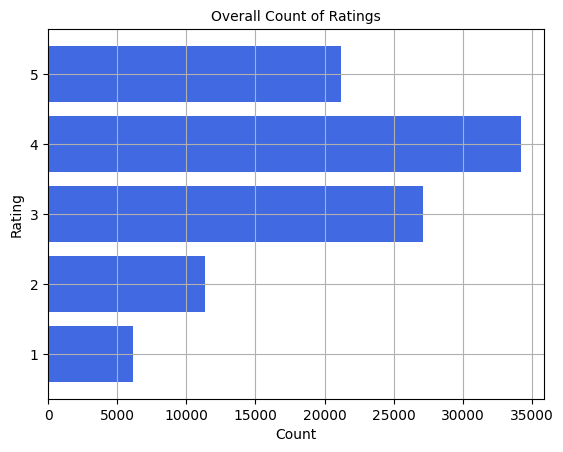

In [14]:
ratings_cnt = ratings.groupby('rating')['userid'].count().rename('cnt_users').reset_index()
plt.barh(ratings_cnt.rating, ratings_cnt.cnt_users, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=10)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid()
plt.show()

Let's check the most and least popular films:

In [15]:
items_popularity = ratings.groupby('itemid')['userid'].count().rename('cnt_users')
pop_result = pd.merge(items_popularity, movies, on='itemid', how='inner')
pop_result.set_index('itemid').sort_values(by='cnt_users', ascending=False).head(10)

,cnt_users,title,year
itemid,,,
50,583,Star Wars (1977),1977
258,509,Contact (1997),1997
100,508,Fargo (1996),1996
181,507,Return of the Jedi (1983),1983
294,485,Liar Liar (1997),1997
286,481,"English Patient, The (1996)",1996
288,478,Scream (1996),1996
1,452,Toy Story (1995),1995
300,431,Air Force One (1997),1997


In [16]:
pop_result.set_index('itemid').sort_values(by='cnt_users', ascending=True).head(10)

,cnt_users,title,year
itemid,,,
1682,1,Scream of Stone (Schrei aus Stein) (1991),1991
814,1,"Great Day in Harlem, A (1994)",1994
1447,1,Century (1993),1993
1593,1,Death in Brunswick (1991),1991
1452,1,Lady of Burlesque (1943),1943
1453,1,Angel on My Shoulder (1946),1946
1457,1,Love Is All There Is (1996),1996
1458,1,"Damsel in Distress, A (1937)",1937
1460,1,Sleepover (1995),1995


### 2. Preprocess dataset

Firsly, label the ids in dataset:

In [17]:
def ids_encoder(ratings):
    users = sorted(ratings['userid'].unique())
    items = sorted(ratings['itemid'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.userid = uencoder.transform(ratings.userid.tolist())
    ratings.itemid = iencoder.transform(ratings.itemid.tolist())

    return ratings, uencoder, iencoder

ratings, uencoder, iencoder = ids_encoder(ratings)

In [18]:
ratings.head()

,userid,itemid,rating
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


Then normalize it:

In [19]:
def normalize_ratings(ratings: pd.DataFrame) -> pd.DataFrame:
    mean = ratings.groupby(by='userid', as_index=False)['rating'].mean()
    norm_ratings = pd.merge(ratings, mean, suffixes=('','_mean'), on='userid')
    norm_ratings['norm_rating'] = norm_ratings['rating'] - norm_ratings['rating_mean']
    return norm_ratings[ratings.columns.tolist() + ['norm_rating']]

In [20]:
ratings = normalize_ratings(ratings)

Let's look at the final version of our ratings data:

In [21]:
ratings.head()

,userid,itemid,rating,norm_rating
0,0,0,5,1.389706
1,0,1,3,-0.610294
2,0,2,4,0.389706
3,0,3,3,-0.610294
4,0,4,3,-0.610294


### 3. I2I similarity calculation

In [35]:
class SimilarityFunctions:
    """
    Class of functions to calculate similarity between items
    """

    def __init__(self):
        pass

    def cosine_sim(self, x: np.array, y: np.array) -> float:
        """
        Cosine similarity function

        Args:
            x (np.array): ratings for one item
            y (np.array): ratings for another item

        Returns:
            float: cosine similarity between two items
        """
        if np.linalg.norm(x) == 0 or np.linalg.norm(y) == 0:
            return 0

        return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

    def intersection_sim(self, x: np.array, y: np.array) -> float:
        """Intersection similarity function

        Args:
            x (np.array): ratings for one item
            y (np.array): ratings for another item

        Returns:
            float: cosine similarity between two items
        """
        return np.dot(x, y)

    def pearson_coef(self, x: np.array, y: np.array) -> float:
        """
        Pearson correlation function

        Args:
            x (np.array): ratings for one item
            y (np.array): ratings for another item

        Returns:
            float: pearson correlation between two items
        """
        if np.linalg.norm(x) == 0 or np.linalg.norm(y) == 0:
            return 0
        if x.shape[0] == 1 or y.shape[0] == 0:
            return 1
        return pearsonr(x, y)[0]


class Item2ItemSimilarities:
    """
    A class to calculate item2item collaborative filtering similarities and neighbors.

    Attributes:
        ratings (pd.Dataframe): The data contains ratings that users put to the items
        movies (pd.Dataframe): The data contains info about movies
        sim_funcs (class SimilarityFunctions): The class with similarity functions
    """
    def __init__(self, ratings, movies):
        self.ratings = ratings.to_numpy()
        self.movies = movies
        self.sim_funcs = SimilarityFunctions()

    @lru_cache(2000)
    def ratings_for_item(self, i: int) -> np.array:
        """Get ratings for the certain item

        Args:
            i (int): index of item to calculate ratings for

        Returns:
            np.array: ratings of item
        """
        return self.ratings[self.ratings[:, 1] == i]

    def calculate_sim_between_two(self, i: int, j: int, sim_func_name: str) -> float:
        """Calculate similarity between two items using certain similarity function

        Args:
            i (int): index of first item
            j (int): index of another item
            sim_func_name (str): name of similarity function

        Returns:
            float: similarity between two items
        """
        sim_func = self.sim_function(sim_func_name)
        if i == j:
            return 1.0
        ratings_i, ratings_j = self.ratings_for_item(i), self.ratings_for_item(j)

        common_users = np.intersect1d(ratings_i[:, 0], ratings_j[:, 0])
        common_ratings_i = ratings_i[np.isin(ratings_i[:, 0], common_users)]
        common_ratings_j = ratings_j[np.isin(ratings_j[:, 0], common_users)]

        if len(common_users) > 0:
            assert sorted(common_ratings_i[:, 0]) == sorted(common_ratings_j[:, 0])
            x = common_ratings_i[:, 3]
            y = common_ratings_j[:, 3]
            return sim_func(x, y)
        return -1.0

    def sim_function(self, func_name: str) -> Callable[[np.array, np.array], float]:
        """Mapping to correctly choose function for
        calculating similarities between items

        Args:
            func_name (str): name of similarity function to use

        Returns:
            Callable[[np.array, np.array], float]: Function to calculate similarity
        """
        if func_name == "cosine":
            return self.sim_funcs.cosine_sim
        if func_name == "pearson":
            return self.sim_funcs.pearson_coef
        if func_name == "intersection":
            return self.sim_funcs.intersection_sim
        else:
            print("There is no such similarity function: {func_name}")

    def calculate_pairwise_sim(self, sim_func_name: str) -> Tuple[np.array, np.array]:
        """Calculate pairwise similaritites for all items

        Args:
            sim_func_name (str): Similarity function name (check `sim_function` method)

        Returns:
            Tuple[np.array, np.array]: Sorted similarities and list of items for each item
        """
        nb_items = np.unique(self.ratings[:, 1]).size
        similarities = np.zeros(shape=(nb_items, nb_items))

        similarities.fill(-1)
        np.fill_diagonal(similarities, 1)

        _items = sorted(set(map(int, self.ratings[:, 1])))
        items = sample(_items, len(_items))

        print(f"Calculating pairwise similarities with {sim_func_name} function...")
        with tqdm(total=len(items) * (len(items) - 1) // 2) as pbar:
            for i in range(len(items)):
                for j in range(i + 1, len(items)):
                    sim = self.calculate_sim_between_two(items[i], items[j], sim_func_name)
                    similarities[items[i], items[j]] = sim
                    similarities[items[j], items[i]] = sim
                    pbar.update()
        assert np.all(similarities.T == similarities), 'Similarity matrix should be symmetrical'
        assert np.allclose(np.diag(similarities), 1.0), 'Similarities of items with themselves should be 1'

        neighbors = np.flip(np.argsort(similarities), axis=1)
        similarities = np.flip(np.sort(similarities), axis=1)

        return similarities, neighbors

    def show_item_neighbors(self, item_id: int, similarities: np.array, neighbors: np.array, k: int = 5) -> None:
        """_summary_

        Args:
            item_id (int): Index of item
            similaritites (np.array): Sorted by values matrix of similarities between items
            neighbors (np.array): Sorted by values matrix of neighbors for each item
            k (int, optional): top items accordings to similarity to take. Defaults to 5.
        """
        film_name = movies[movies.itemid == iencoder.inverse_transform([item_id])[0]].title.values[0]
        similar_films = (
            (neighbor_id, self.movies[self.movies.itemid == iencoder.inverse_transform([neighbor_id])[0]].title.values[0], similarity)
            for neighbor_id, similarity in zip(neighbors[item_id][:k], similarities[item_id][:k])
        )
        display(pd.DataFrame(dict(zip(('item_id', film_name, 'Similarity'), zip(*similar_films)))))

In [36]:
i2i = Item2ItemSimilarities(ratings=ratings, movies=movies)

In [37]:
sim_cosine, neigh_cosine = i2i.calculate_pairwise_sim("cosine")

[485, 484, 1245, 114, 757, 117, 479, 89, 972, 1422, 151, 871, 344, 1640, 1100, 539, 942, 1308, 681, 443, 1419, 1545, 697, 1288, 1008, 560, 331, 367, 1661, 1035, 865, 1625, 536, 657, 99, 1338, 1619, 1597, 493, 482, 1554, 1345, 1361, 1659, 1123, 1134, 1671, 1293, 529, 235, 624, 1440, 1478, 649, 747, 556, 1036, 1396, 758, 270, 122, 838, 488, 678, 739, 615, 1575, 503, 1568, 458, 778, 1207, 610, 1079, 1343, 1286, 1537, 1485, 1106, 980, 445, 714, 690, 1122, 160, 1175, 849, 1085, 207, 437, 1347, 578, 1073, 1315, 95, 992, 955, 1179, 707, 136, 724, 455, 1502, 540, 1376, 900, 241, 1076, 229, 1624, 232, 119, 1219, 1344, 1050, 487, 1635, 1260, 1053, 1357, 1435, 521, 1330, 1669, 1132, 272, 962, 1666, 1183, 154, 65, 373, 1491, 825, 124, 1543, 886, 1459, 676, 1618, 1024, 1147, 384, 802, 1670, 545, 293, 1386, 1586, 189, 844, 1115, 548, 1232, 1469, 1516, 1145, 1305, 1433, 1353, 550, 1095, 1561, 832, 1335, 24, 660, 1094, 991, 1222, 1641, 246, 1138, 1451, 501, 1254, 940, 1644, 1250, 1604, 1109, 637, 1046

  0%|          | 0/1413721 [00:00<?, ?it/s]

In [38]:
sim_inter, neigh_inter = i2i.calculate_pairwise_sim("intersection")

[492, 629, 198, 1427, 321, 1662, 466, 656, 1206, 1227, 312, 1288, 1681, 1580, 795, 968, 952, 88, 753, 801, 879, 1519, 538, 1472, 507, 306, 424, 802, 1525, 264, 818, 11, 487, 165, 148, 1237, 329, 1160, 1129, 1141, 440, 236, 114, 659, 814, 1376, 909, 57, 1367, 563, 1538, 505, 615, 230, 1031, 1198, 1404, 850, 1025, 1399, 18, 319, 891, 558, 105, 1175, 1111, 922, 1650, 1105, 745, 1425, 1353, 768, 808, 945, 709, 151, 1296, 605, 877, 61, 262, 484, 1357, 209, 1077, 870, 1490, 1142, 1205, 830, 1116, 1229, 719, 76, 965, 1510, 841, 743, 581, 1332, 408, 1500, 1016, 1531, 428, 171, 928, 769, 302, 552, 1501, 1029, 914, 122, 584, 683, 958, 301, 776, 1089, 1590, 519, 634, 1379, 214, 774, 1446, 702, 1542, 1630, 1238, 407, 984, 370, 1248, 1113, 1362, 1321, 557, 862, 257, 233, 478, 589, 838, 84, 1153, 218, 661, 1276, 135, 528, 22, 1249, 813, 307, 141, 644, 1554, 727, 1272, 609, 423, 297, 530, 23, 1050, 103, 81, 541, 1222, 865, 1255, 975, 335, 988, 995, 108, 331, 1512, 1556, 9, 898, 163, 1568, 1513, 1455,

  0%|          | 0/1413721 [00:00<?, ?it/s]

In [39]:
i2i.show_item_neighbors(0, sim_cosine, neigh_cosine)

,item_id,Toy Story (1995),Similarity
0,1260,"Run of the Country, The (1995)",1.0
1,1188,Prefontaine (1997),1.0
2,1559,Clean Slate (Coup de Torchon) (1981),1.0
3,0,Toy Story (1995),1.0
4,756,Across the Sea of Time (1995),1.0


In [40]:
np.where(neigh_cosine[0] == 317), sim_cosine[0][158]


((array([158]),), 0.36539748193267635)

In [41]:
i2i.show_item_neighbors(0, sim_inter, neigh_inter)

,item_id,Toy Story (1995),Similarity
0,49,Star Wars (1977),124.387738
1,173,Raiders of the Lost Ark (1981),112.075258
2,180,Return of the Jedi (1983),82.044059
3,171,"Empire Strikes Back, The (1980)",77.921730
4,317,Schindler's List (1993),71.702327


Let's look at similarity distribution:

In [42]:
def plot_pdf(values: np.ndarray, title: str):
    """Plots `values` distribution density"""
    plt.figure(figsize=(10, 5))
    plt.violinplot(values.flatten(), vert=False, showmedians=True)
    plt.xlabel("Similarity")
    plt.grid()
    plt.title(title)
    plt.show()

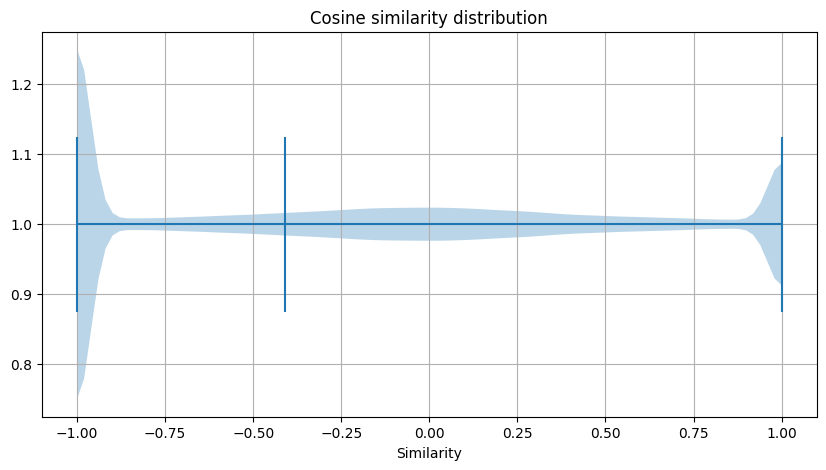

In [43]:
plot_pdf(sim_cosine, "Cosine similarity distribution")

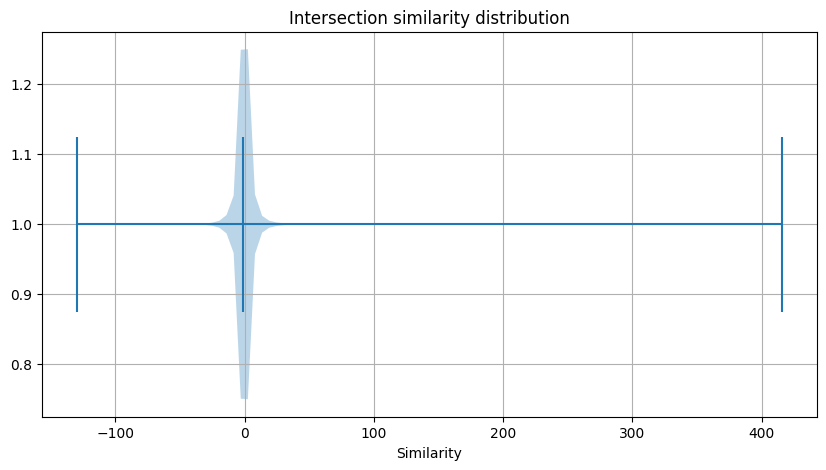

In [68]:
plot_pdf(sim_inter, "Intersection similarity distribution")

### 4. I2I recommendations

In [45]:
class Item2ItemRecomendations:
    """
    A class to provide item2item recommendations for user.
    Attributes:
        ratings (pd.Dataframe): The data contains ratings that users put to the items
        movies (pd.Dataframe): The data contains info about movies
        similaritites (np.array): Sorted by values matrix of similarities between items
        neighbors (np.array): Sorted by values matrix of neighbors for each item
    """
    def __init__(self, ratings, movies, neighbors, similarities):
        self.ratings = ratings.to_numpy()
        self.movies = movies
        self.neighbors = neighbors
        self.similarities = similarities

    def candidate_items(self, userid: int, k: int = -1) -> Tuple[np.array, np.array]:
        """Get candidate items for user

        Args:
            userid (int): Index of user
            k (int, optional): Number of candidates to take. Defaults to -1.

        Returns:
            Tuple[np.array, np.array]: Set of items already rated by user and candidates for user
        """
        # 1. Finding the set I_u of items already rated by user userid
        I_u = self.ratings[self.ratings[:, 0] == userid]
        I_u = I_u[:, 1].astype('int')

        # 2. Taking the union of similar items for all items in I_u to form the set of candidate items
        c = set()

        for iid in I_u:
            # add the neighbors of item iid in the set of candidate items
            c.update(self.neighbors[iid, :k])

        c = list(c)
        # 3. exclude from the set C all items in I_u.
        candidates = np.setdiff1d(c, I_u, assume_unique=True)

        return I_u, candidates

    def similarity_with_Iu(self, item_id: int, I_u: np.array) -> float:
        """Calculate similarity weight according to user interactions

        Args:
            item_id (int): Index of item
            I_u (np.array): Set of items already rated by user

        Returns:
            float: Similarity weight
        """
        w = 0
        for iid in I_u:
            # get similarity between itemid and c, if c is one of the k nearest neighbors of itemid
            if item_id in self.neighbors[iid]:
                w = w + self.similarities[iid, self.neighbors[iid] == item_id][0]
        return w

    def rank_candidates(self, candidates: np.array, I_u: np.array) -> List:
        """Rank candidates according to their similarity weights

        Args:
            candidates (np.array): item candidates
            I_u (np.array): Set of items already rated by user

        Returns:
            np.array: _description_
        """
        # list of candidate items mapped to their corresponding similarities to I_u
        sims = [self.similarity_with_Iu(c, I_u) for c in candidates]
        candidates = iencoder.inverse_transform(candidates)
        mapping = list(zip(candidates, sims))

        ranked_candidates = sorted(mapping, key=lambda couple:couple[1], reverse=True)
        return ranked_candidates

    def topn_recommendation(self, userid: int, k: int = -1, N=30) -> pd.DataFrame:
        """Show top-N recommendations for user

        Args:
            userid (int): Index of user
            k (int, optional): Number of candidates. Defaults to -1.
            N (int, optional): Number of recommendations to show. Defaults to 30.

        Returns:
            pd.Dataframe: top-N recommendations with info
        """
        # find candidate items
        I_u, candidates = self.candidate_items(userid, k)

        # rank candidate items according to their similarities with I_u
        ranked_candidates = self.rank_candidates(candidates, I_u)

        # get the first N row of ranked_candidates to build the top N recommendation list
        topn = pd.DataFrame(ranked_candidates[:N], columns=['itemid','similarity_with_Iu'])
        topn = pd.merge(topn, movies, on='itemid', how='inner')
        return topn

In [46]:
i2i_rec = Item2ItemRecomendations(ratings, movies, neigh_inter, sim_inter)

In [47]:
i2i_cos = Item2ItemRecomendations(ratings, movies, neigh_cosine, sim_cosine)

Look at recommendations for the certain user:

In [48]:
i2i_cos.topn_recommendation(uencoder.transform([901])[0])

,itemid,similarity_with_Iu,title,year
0,766,21.813759,Man of the Year (1995),1995
1,1387,17.246929,Fall (1997),1997
2,1189,16.636060,Prefontaine (1997),1997
3,1063,14.784693,"Little Princess, A (1995)",1995
4,279,14.427661,Once Upon a Time... When We Were Colored (1995),1995
5,1516,13.476772,"Wedding Gift, The (1994)",1994
6,1519,12.666387,New Jersey Drive (1995),1995
7,1053,12.637237,Now and Then (1995),1995
8,1044,11.507898,"Paper, The (1994)",1994
9,692,11.043056,"American President, The (1995)",1995


In [49]:
i2i_rec.topn_recommendation(uencoder.transform([901])[0])

,itemid,similarity_with_Iu,title,year
0,79,1723.078833,"Fugitive, The (1993)",1993
1,173,1699.000734,"Princess Bride, The (1987)",1987
2,64,1593.155040,"Shawshank Redemption, The (1994)",1994
3,186,1320.880390,"Blues Brothers, The (1980)",1980
4,98,1241.856225,"Silence of the Lambs, The (1991)",1991
5,176,1187.556334,Aliens (1986),1986
6,318,1180.525812,Schindler's List (1993),1993
7,265,1095.108876,"Hunt for Red October, The (1990)",1990
8,313,1074.418529,Titanic (1997),1997
9,215,1013.448162,Field of Dreams (1989),1989


## 5. Item2item using scikit-surprise

In [50]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357288 sha256=4cf68d51daf5d71eb9f01e7b0e9528985965586c939092acaf2a2654b22d2332
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [51]:
from surprise import KNNWithMeans
from surprise import Reader, Dataset
import time

In [52]:
ratings, movies = ml100k.load()
ratings, uencoder, iencoder = ids_encoder(ratings)

In [53]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(ratings[['userid', 'itemid', 'rating']], reader)
trainset = data.build_full_trainset()

In [54]:
trainset.all_items()

range(0, 1682)

In [55]:
trainset.all_users()

range(0, 943)

In [56]:
start_time = time.time()
algo_i2i = KNNWithMeans(k=40, sim_options={'name': 'cosine', 'user_based': False, 'verbose' : True})

algo_i2i.fit(trainset);
print("--- %s seconds ---" % (time.time() - start_time))

Computing the cosine similarity matrix...
Done computing similarity matrix.
--- 2.2257590293884277 seconds ---


In [57]:
def get_top_n_recommendations(algo, user_id, trainset, n=30):
    all_items = set(trainset.all_items())
    rated_items = {iid for (uid, iid) in trainset.ur[trainset.to_inner_uid(user_id)]}

    unrated_items = all_items - rated_items

    predictions = []
    for item in unrated_items:
        pred = algo.predict(user_id, trainset.to_raw_iid(item))
        predictions.append((iencoder.inverse_transform([pred.iid])[0], pred.est))

    cands = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    topn = pd.DataFrame(cands, columns=['itemid', "est"])
    topn = pd.merge(topn, movies, on='itemid', how='inner')

    return topn

In [58]:
start_time = time.time()
print(get_top_n_recommendations(algo_i2i, 276, trainset))
print("--- %s seconds ---" % (time.time() - start_time))

    itemid       est                                              title
0     1201  5.000000         Marlene Dietrich: Shadow and Light (1996) 
1     1293  5.000000                                    Star Kid (1997)
2     1653  5.000000  Entertaining Angels: The Dorothy Day Story (1996)
3     1536  4.923019                               Aiqing wansui (1994)
4      814  4.892484                      Great Day in Harlem, A (1994)
5     1189  4.853955                                 Prefontaine (1997)
6     1467  4.808563               Saint of Fort Washington, The (1993)
7     1500  4.785740                          Santa with Muscles (1996)
8     1599  4.742919                      Someone Else's America (1995)
9     1122  4.619394                     They Made Me a Criminal (1939)
10    1449  4.597967                             Pather Panchali (1955)
11     408  4.477704                              Close Shave, A (1995)
12    1235  4.459294                        Big Bang Theory, The

In [59]:
a = i2i_rec.topn_recommendation(uencoder.transform([277])[0]).itemid.to_numpy()
b = get_top_n_recommendations(algo_i2i,276, trainset).itemid.to_numpy()
np.intersect1d(a, b)

array([ 12,  64, 127, 272, 318])

## 6. I2I and U2U recommendations

In [60]:
ratings, movies = ml1m.load()
ratings, uencoder, iencoder = ids_encoder(ratings)


reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(ratings[['userid', 'itemid', 'rating']], reader)
trainset = data.build_full_trainset()

Download data 100.1%
Successfully downloaded ml-1m.zip 5917549 bytes.
Unzipping the ml-1m.zip zip file ...


In [61]:
start_time = time.time()
algo_i2i = KNNWithMeans(k=40, sim_options={'name': 'cosine', 'user_based': False, 'verbose' : True})

algo_i2i.fit(trainset);
print("--- %s seconds ---" % (time.time() - start_time))

Computing the cosine similarity matrix...
Done computing similarity matrix.
--- 32.52696704864502 seconds ---


In [62]:
start_time = time.time()
algo_u2u = KNNWithMeans(k=40, sim_options={'name': 'cosine', 'user_based': True, 'verbose' : True})

algo_u2u.fit(trainset);
print("--- %s seconds ---" % (time.time() - start_time))

Computing the cosine similarity matrix...
Done computing similarity matrix.
--- 113.38190865516663 seconds ---


In [63]:
trainset.all_items()

range(0, 3706)

In [64]:
trainset.all_users()

range(0, 6040)

Let's look at i2i and u2u recommendations for certain user (id 276):

In [ ]:
start_time = time.time()
print(get_top_n_recommendations(algo_i2i, 276, trainset))
print("--- %s seconds ---" % (time.time() - start_time))

In [65]:
start_time = time.time()
print(get_top_n_recommendations(algo_u2u, 276, trainset))
print("--- %s seconds ---" % (time.time() - start_time))

    itemid       est                                      title  \
0      578  5.000000                Hour of the Pig, The (1993)   
1      557  5.000000                          Mamma Roma (1962)   
2      989  5.000000  Schlafes Bruder (Brother of Sleep) (1995)   
3     1830  5.000000                    Follow the Bitch (1998)   
4     3382  5.000000                     Song of Freedom (1936)   
5     3245  4.863580        I Am Cuba (Soy Cuba/Ya Kuba) (1964)   
6      758  4.855352                  Jar, The (Khomreh) (1992)   
7      787  4.845669         Gate of Heavenly Peace, The (1995)   
8     2503  4.833189                    Apple, The (Sib) (1998)   
9     2762  4.804788                    Sixth Sense, The (1999)   
10    3323  4.800000                      Chain of Fools (2000)   
11    3517  4.786103                          Bells, The (1926)   
12    3233  4.727273                       Smashing Time (1967)   
13    3607  4.714927                   One Little Indian (1973

In [66]:
a = get_top_n_recommendations(algo_i2i, 276, trainset).itemid.to_numpy()
b = get_top_n_recommendations(algo_u2u, 276, trainset).itemid.to_numpy()
np.intersect1d(a, b)

array([  53,  578,  787,  989, 1830, 2480, 2503, 2905, 3172, 3233, 3245,
       3280, 3382, 3517, 3607, 3881])